<a href="https://www.kaggle.com/code/adastroabyssosque/loan-approval-prediction-with-cascade-models?scriptVersionId=203378901" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


# import data

In [2]:
loan_tr = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
loan_te = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
loan_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

## drop id

stored id in test data as `test_id`

In [3]:
loan_tr = loan_tr.drop(columns = ['id'])
loan_tr.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [4]:
test_id = loan_te['id']
loan_te = loan_te.drop(columns = ['id'])
loan_te.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')

# Overview on train data by column

## min max scaler

In [5]:
def min_max_scaler(col):
    return (col-col.min())/(col.max()-col.min())

## styles first: create a color palette

In [6]:
import matplotlib.colors as colors

color_l = [ '#445E93', '#7EB2DD','#FCECC9','#FCB0B3','#F93943']
is_cat = colors.ListedColormap(name = 'imperial spring', colors = color_l)
is_uncat = colors.LinearSegmentedColormap.from_list(name = 'imperial spring', colors = color_l)
data = np.random.rand(10, 10)*10

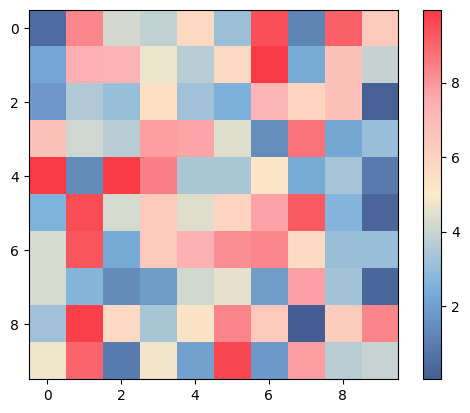

In [7]:
# display to see outcome
from matplotlib import pyplot as plt

plt.imshow(data, cmap=is_uncat)
plt.colorbar()

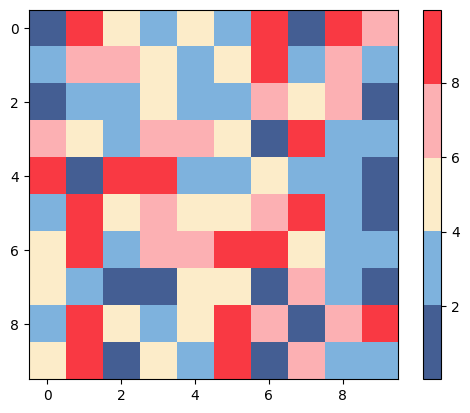

In [8]:
plt.imshow(data, cmap = is_cat)
plt.colorbar()

## loan status

In [9]:
loan_tr.loan_status.head(5)

0    0
1    0
2    0
3    0
4    0
Name: loan_status, dtype: int64

In [10]:
loan_tr.loan_status.unique()

array([0, 1])

In [11]:
loan_tr.loan_status.describe()

count    58645.000000
mean         0.142382
std          0.349445
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: loan_status, dtype: float64

## age

In [12]:
loan_tr.person_age.describe()

count    58645.000000
mean        27.550857
std          6.033216
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        123.000000
Name: person_age, dtype: float64

In [13]:
loan_te.person_age.describe()

count    39098.000000
mean        27.566781
std          6.032761
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max         94.000000
Name: person_age, dtype: float64

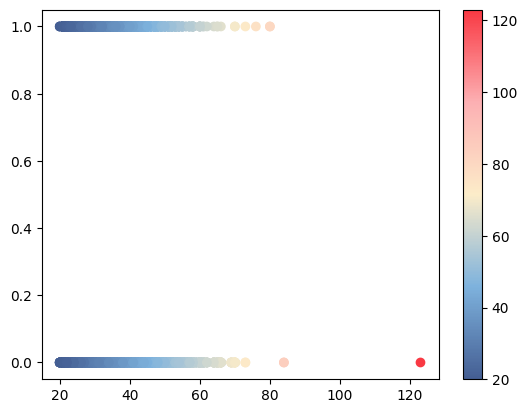

In [14]:
plt.scatter(loan_tr.person_age, loan_tr.loan_status, c = loan_tr.person_age, cmap = is_uncat)
plt.colorbar()

### a bit manipulation on person age and cred history length
doing this cause these columns has 0.87 correlation, and they both has a high value from F classification to response varaible. (For more information of it, see this script in previous history)

In [15]:
loan_tr.cb_person_cred_hist_length.describe()

count    58645.000000
mean         5.813556
std          4.029196
min          2.000000
25%          3.000000
50%          4.000000
75%          8.000000
max         30.000000
Name: cb_person_cred_hist_length, dtype: float64

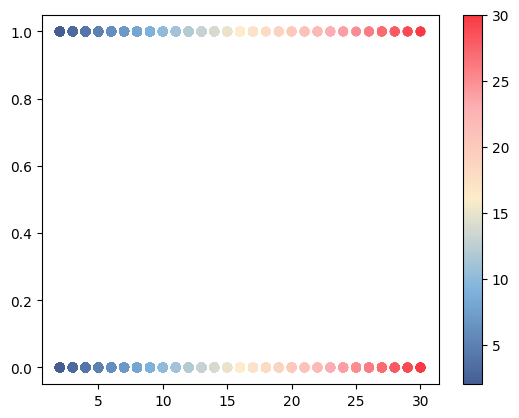

In [16]:
plt.scatter(loan_tr.cb_person_cred_hist_length, loan_tr.loan_status, c = loan_tr.cb_person_cred_hist_length, cmap = is_uncat)
plt.colorbar()

In [17]:
loan_tr.insert(0, 'age_cred_time_ratio', loan_tr.person_age/loan_tr.cb_person_cred_hist_length)
loan_tr['age_cred_time_ratio'] = min_max_scaler(loan_tr.age_cred_time_ratio)
loan_tr.age_cred_time_ratio.describe()

count    58645.000000
mean         0.182434
std          0.102597
min          0.000000
25%          0.093488
50%          0.160637
75%          0.236179
max          1.000000
Name: age_cred_time_ratio, dtype: float64

In [18]:
loan_tr.insert(0, 'emp_length_cred_time_ratio', loan_tr.person_emp_length/loan_tr.cb_person_cred_hist_length)

loan_tr['emp_length_cred_time_ratio'] = min_max_scaler(loan_tr.emp_length_cred_time_ratio)
loan_tr.emp_length_cred_time_ratio.describe()

count    58645.000000
mean         0.018341
std          0.017786
min          0.000000
25%          0.004782
50%          0.013008
75%          0.027100
max          1.000000
Name: emp_length_cred_time_ratio, dtype: float64

In [19]:
loan_tr.insert(0, 'age_salary_ratio', loan_tr.person_age/loan_tr.person_income)

loan_tr['age_salary_ratio'] = min_max_scaler(loan_tr.age_salary_ratio)
loan_tr.age_salary_ratio.describe()

count    58645.000000
mean         0.086744
std          0.045894
min          0.000000
25%          0.055914
50%          0.076604
75%          0.106261
max          1.000000
Name: age_salary_ratio, dtype: float64

In [20]:
loan_te.insert(0, 'emp_length_cred_time_ratio', loan_te.person_emp_length/loan_te.cb_person_cred_hist_length)

loan_te['emp_length_cred_time_ratio'] = min_max_scaler(loan_te.emp_length_cred_time_ratio)
loan_te.emp_length_cred_time_ratio.describe()

count    39098.000000
mean         0.080414
std          0.075799
min          0.000000
25%          0.020408
50%          0.057143
75%          0.119048
max          1.000000
Name: emp_length_cred_time_ratio, dtype: float64

In [21]:
loan_te.insert(0, 'age_cred_time_ratio', loan_te.person_age/loan_te.cb_person_cred_hist_length)
loan_te['age_cred_time_ratio'] = min_max_scaler(loan_te.age_cred_time_ratio)
loan_te.age_cred_time_ratio.describe()

count    39098.000000
mean         0.185003
std          0.115791
min          0.000000
25%          0.084906
50%          0.160377
75%          0.245283
max          1.000000
Name: age_cred_time_ratio, dtype: float64

In [22]:
loan_te.insert(0, 'age_salary_ratio', loan_te.person_age/loan_te.person_income)

loan_te['age_salary_ratio'] = min_max_scaler(loan_te.age_salary_ratio)
loan_te.age_salary_ratio.describe()

count    39098.000000
mean         0.051328
std          0.027797
min          0.000000
25%          0.033070
50%          0.045310
75%          0.063113
max          1.000000
Name: age_salary_ratio, dtype: float64

In [23]:
loan_tr['person_age'] = min_max_scaler(loan_tr.person_age)
loan_tr['cb_person_cred_hist_length'] = min_max_scaler(loan_tr.cb_person_cred_hist_length)
loan_te['person_age'] = min_max_scaler(loan_te.person_age)
loan_te['cb_person_cred_hist_length'] = min_max_scaler(loan_te.cb_person_cred_hist_length)

## person_income

In [24]:
loan_tr.person_income.describe()

count    5.864500e+04
mean     6.404617e+04
std      3.793111e+04
min      4.200000e+03
25%      4.200000e+04
50%      5.800000e+04
75%      7.560000e+04
max      1.900000e+06
Name: person_income, dtype: float64

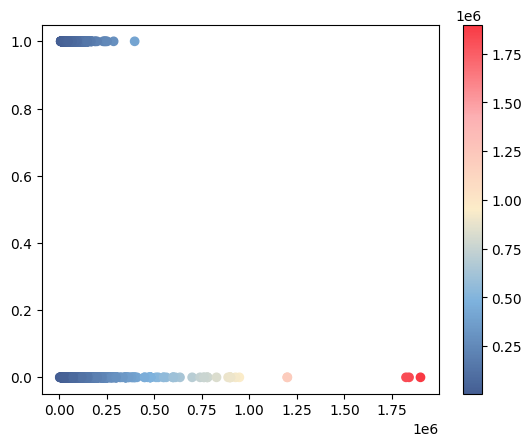

In [25]:
plt.scatter(loan_tr.person_income, loan_tr.loan_status, c = loan_tr.person_income, cmap = is_uncat)
plt.colorbar()

we can see that at least in our train data, only people with lower income would have loan satus = 1

In [26]:
loan_tr['person_income'] = min_max_scaler(loan_tr.person_income)
loan_tr['person_income'].head()

0    0.016246
1    0.027324
2    0.012976
3    0.034708
4    0.029433
Name: person_income, dtype: float64

In [27]:
loan_te['person_income'] = min_max_scaler(loan_te.person_income)
loan_te['person_income'].head()

0    0.034283
1    0.048523
2    0.013713
3    0.024262
4    0.051688
Name: person_income, dtype: float64

## person_home_ownership

In [28]:
loan_tr.columns

Index(['age_salary_ratio', 'emp_length_cred_time_ratio', 'age_cred_time_ratio',
       'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [29]:
loan_tr.person_home_ownership.describe()

count     58645
unique        4
top        RENT
freq      30594
Name: person_home_ownership, dtype: object

In [30]:
loan_tr['person_home_ownership'] = loan_tr['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3})

/tmp/ipykernel_17/1129636332.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  loan_tr['person_home_ownership'] = loan_tr['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3})


In [31]:
loan_te['person_home_ownership'] = loan_te['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3})

/tmp/ipykernel_17/1158413557.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  loan_te['person_home_ownership'] = loan_te['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3})


## person_emp_length

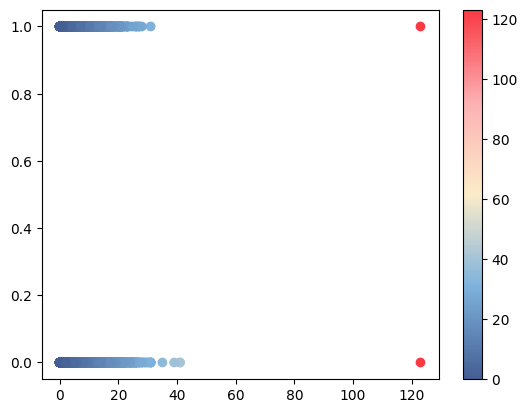

In [32]:
plt.scatter(loan_tr.person_emp_length, loan_tr.loan_status, c = loan_tr.person_emp_length, cmap = is_uncat)
plt.colorbar()

In [33]:
loan_tr['person_emp_length'] = min_max_scaler(loan_tr.person_emp_length)
loan_tr['person_emp_length'].head()

0    0.000000
1    0.048780
2    0.065041
3    0.113821
4    0.016260
Name: person_emp_length, dtype: float64

In [34]:
loan_te['person_emp_length'] = min_max_scaler(loan_te.person_emp_length)
loan_te['person_emp_length'].head()

0    0.071429
1    0.142857
2    0.119048
3    0.095238
4    0.190476
Name: person_emp_length, dtype: float64

## loan_intent

In [35]:
loan_tr.loan_intent.info()

<class 'pandas.core.series.Series'>
RangeIndex: 58645 entries, 0 to 58644
Series name: loan_intent
Non-Null Count  Dtype 
--------------  ----- 
58645 non-null  object
dtypes: object(1)
memory usage: 458.3+ KB


In [36]:
loan_tr.groupby(by = 'loan_intent')['loan_intent'].count()

loan_intent
DEBTCONSOLIDATION     9133
EDUCATION            12271
HOMEIMPROVEMENT       6280
MEDICAL              10934
PERSONAL             10016
VENTURE              10011
Name: loan_intent, dtype: int64

In [37]:
loan_te.groupby(by='loan_intent')['loan_intent'].count()

loan_intent
DEBTCONSOLIDATION    5915
EDUCATION            8076
HOMEIMPROVEMENT      4213
MEDICAL              7447
PERSONAL             6815
VENTURE              6632
Name: loan_intent, dtype: int64

In [38]:
loan_tr['loan_intent'] = loan_tr['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5})

/tmp/ipykernel_17/1002611104.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  loan_tr['loan_intent'] = loan_tr['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5})


In [39]:
loan_tr['loan_intent'] = loan_tr['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5})

## loan grade

In [40]:
loan_tr.loan_grade.info()

<class 'pandas.core.series.Series'>
RangeIndex: 58645 entries, 0 to 58644
Series name: loan_grade
Non-Null Count  Dtype 
--------------  ----- 
58645 non-null  object
dtypes: object(1)
memory usage: 458.3+ KB


In [41]:
loan_tr.loan_grade.unique()

array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object)

In [42]:
loan_te.loan_grade.unique()

array(['F', 'C', 'E', 'A', 'D', 'B', 'G'], dtype=object)

In [43]:
grade_dict = {'A':1,'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
loan_tr.loan_grade = loan_tr.loan_grade.apply(lambda x: grade_dict[x])

In [44]:
loan_te.loan_grade = loan_te.loan_grade.apply(lambda x: grade_dict[x])

In [45]:
loan_te.loan_grade.head()

0    6
1    3
2    5
3    1
4    4
Name: loan_grade, dtype: int64

### loan_int_rate and loan_grade
These columns has a corr of 0.94 (see previous version of this script for more information)

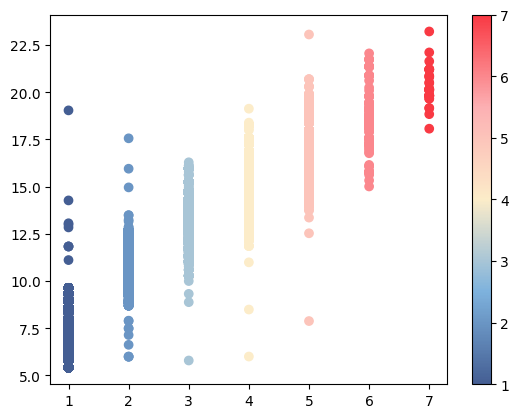

In [46]:
plt.scatter(loan_tr.loan_grade, loan_tr.loan_int_rate, c = loan_tr.loan_grade, cmap = is_uncat)
plt.colorbar()

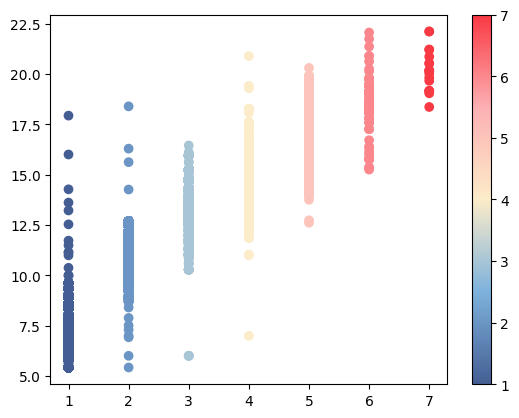

In [47]:
plt.scatter(loan_te.loan_grade, loan_te.loan_int_rate, c = loan_te.loan_grade, cmap = is_uncat)
plt.colorbar()

## loan amnt

In [48]:
loan_tr.loan_amnt.describe()

count    58645.000000
mean      9217.556518
std       5563.807384
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

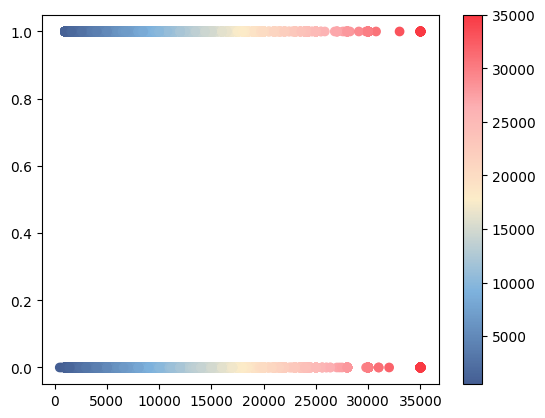

In [49]:
plt.scatter(loan_tr.loan_amnt, loan_tr.loan_status, c = loan_tr.loan_amnt, cmap = is_uncat)
plt.colorbar()

In [50]:
loan_tr['loan_amnt'] = min_max_scaler(loan_tr.loan_amnt)
loan_tr['loan_amnt'].head()

0    0.159420
1    0.101449
2    0.159420
3    0.333333
4    0.159420
Name: loan_amnt, dtype: float64

In [51]:
loan_te['loan_amnt'] = min_max_scaler(loan_te.loan_amnt)
loan_te['loan_amnt'].head()

0    0.708455
1    0.271137
2    0.096210
3    0.183673
4    0.416910
Name: loan_amnt, dtype: float64

## loan_int_rate

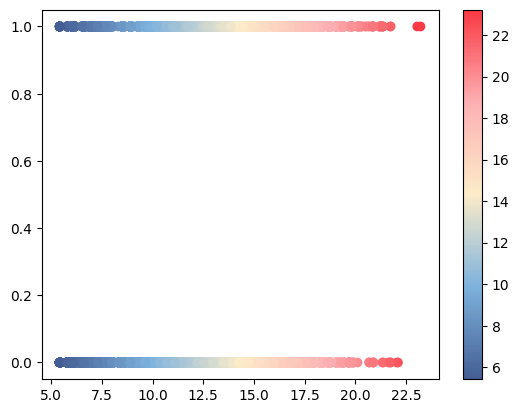

In [52]:
plt.scatter(loan_tr.loan_int_rate, loan_tr.loan_status, c = loan_tr.loan_int_rate, cmap = is_uncat)
plt.colorbar()

In [53]:
loan_tr['loan_int_rate'] = min_max_scaler(loan_tr.loan_int_rate)
loan_tr['loan_int_rate'].head()

0    0.341011
1    0.445506
2    0.195506
3    0.319663
4    0.084270
Name: loan_int_rate, dtype: float64

In [54]:
loan_te['loan_int_rate'] = min_max_scaler(loan_te.loan_int_rate)
loan_te['loan_int_rate'].head()

0    0.619533
1    0.434991
2    0.705213
3    0.208508
4    0.653086
Name: loan_int_rate, dtype: float64

## loan_percent_income

In [55]:
loan_tr.loan_percent_income.describe()

count    58645.000000
mean         0.159238
std          0.091692
min          0.000000
25%          0.090000
50%          0.140000
75%          0.210000
max          0.830000
Name: loan_percent_income, dtype: float64

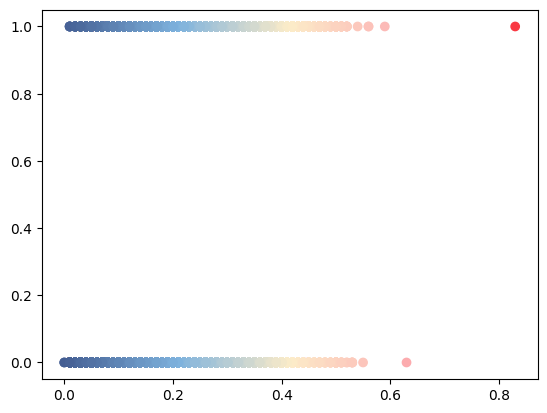

In [56]:
plt.scatter(loan_tr.loan_percent_income, loan_tr.loan_status, c = loan_tr.loan_percent_income, cmap = is_uncat)

## cb_person_default_on_file

In [57]:
loan_tr.cb_person_default_on_file.describe()

count     58645
unique        2
top           N
freq      49943
Name: cb_person_default_on_file, dtype: object

In [58]:
loan_tr.cb_person_default_on_file.unique()

array(['N', 'Y'], dtype=object)

In [59]:
loan_tr = pd.get_dummies(loan_tr, columns = ['cb_person_default_on_file'], prefix = 'cb')

In [60]:
loan_tr.head(1)

,age_salary_ratio,emp_length_cred_time_ratio,age_cred_time_ratio,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,cb_N,cb_Y
0,0.175997,0.0,0.056316,0.165049,0.016246,0,0.0,0,2,0.15942,0.341011,0.17,0.428571,0,True,False


In [61]:
loan_tr = loan_tr.drop(columns =['cb_Y'], axis=1)

In [62]:
loan_te = pd.get_dummies(loan_te, columns = ['cb_person_default_on_file'], prefix = 'cb')
loan_te = loan_te.drop(columns =['cb_Y'], axis=1)

# Analysis on correlation btw features and btw X and Y

## split X and Y

In [63]:
y = loan_tr['loan_status']
X = loan_tr.drop(columns=['loan_status'], axis=1)
X.head(1)

,age_salary_ratio,emp_length_cred_time_ratio,age_cred_time_ratio,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,cb_N
0,0.175997,0.0,0.056316,0.165049,0.016246,0,0.0,0,2,0.15942,0.341011,0.17,0.428571,True


## corr matrix

In [64]:
y = loan_tr.pop('loan_status')

In [65]:
loan_tr.insert(loan_tr.shape[1],'loan_status', y)

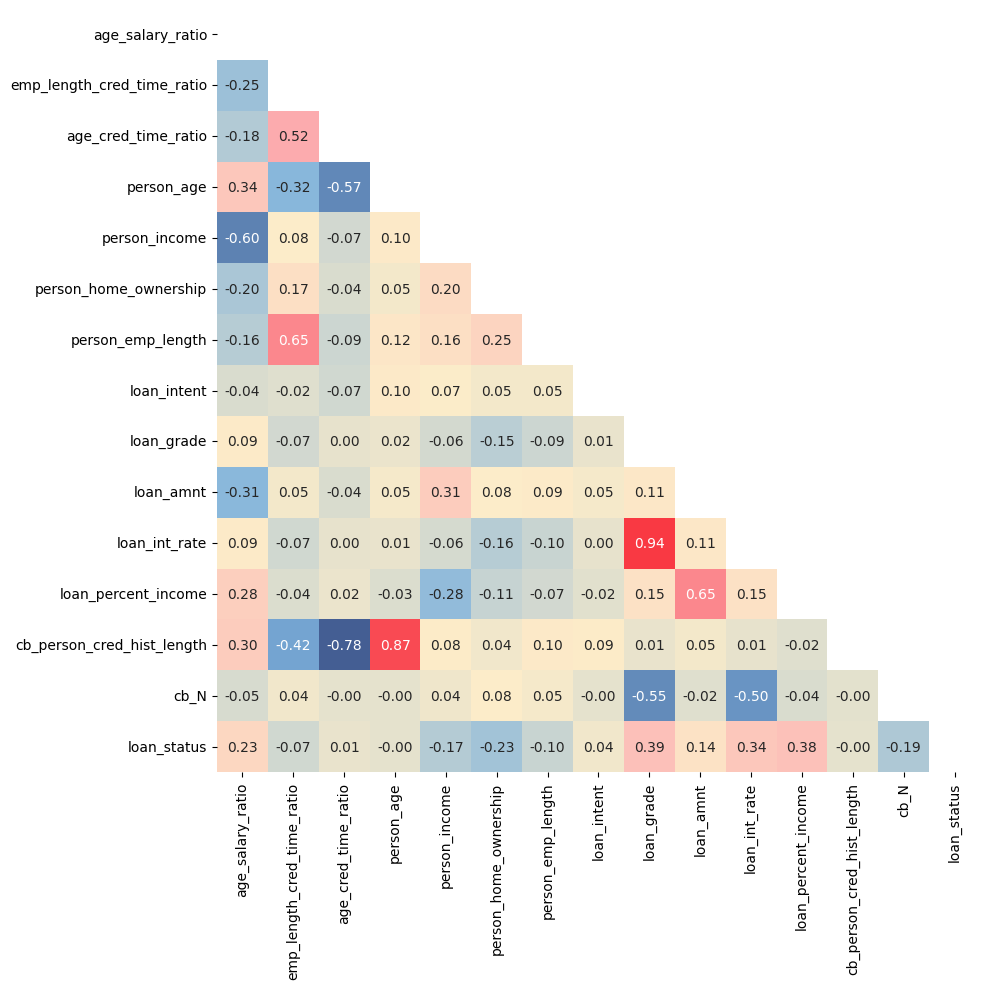

In [66]:
import seaborn as sns
corr = loan_tr.corr()
matrix = np.triu(corr)
fig, ax = plt.subplots(figsize=(len(data[0]), len(data)))
sns.heatmap(corr, annot=True, cbar=False,fmt='.2f', cmap = is_uncat, ax=ax, mask=matrix)
plt.tight_layout()

## mutual information

In [67]:
from sklearn.feature_selection import mutual_info_classif
info = mutual_info_classif(X, y)

In [68]:
print(info)

[0.07436913 0.008354   0.00149785 0.         0.09684447 0.03667415
 0.00826519 0.00573487 0.08043913 0.01687214 0.08238763 0.07850577
 0.00183697 0.0248913 ]


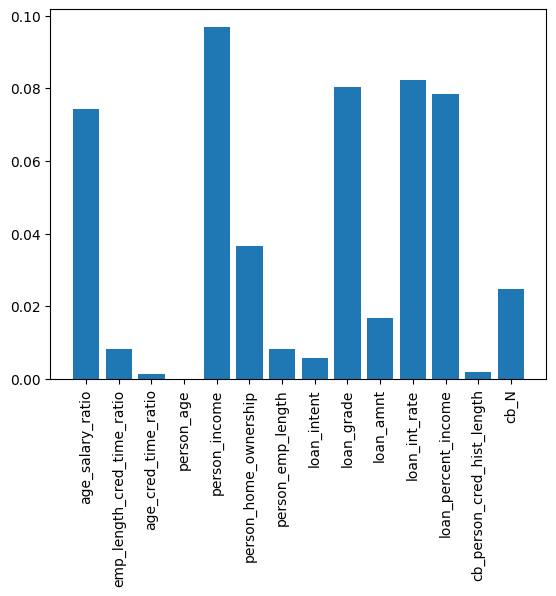

In [69]:
plt.bar(X.columns, info)
tmp = plt.xticks(rotation=90)

Because loan_int_rate and loan_grade are highly correlated. we should drop 1.

# cascade model fitting and hyper parameter tuning

1. LGBM: gives probability of points belong to which category -> training data
2. KNN; gives a rough prediction -> training data
3. XGBoost: gives the final prediction

In [70]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import f_classif
from sklearn.utils import class_weight
import lightgbm as lgb

In [71]:
X_xgb_tr, X_xgb_te, y_xgb_tr, y_xgb_te = train_test_split(X,y, test_size=0.8, stratify = y)

## test the baseline model: KNN

In [72]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2, weights='distance')
knn.fit(X_xgb_tr,y_xgb_tr)
knn_pred = knn.predict(X_xgb_te)
print(roc_auc_score(y_xgb_te, knn_pred))

0.7691904812504426


## Optuna study

In [73]:
def objective(trial):
    params = {
        'model_xgb':{
            'objective': 'binary:logistic',                   
            'eval_metric': 'auc',     
            'learning_rate': trial.suggest_float('learning_rate_xgb', 1e-5, 0.1),
            'max_depth': trial.suggest_int('max_depth_xgb',3, 100),
            'n_estimators': trial.suggest_int('n_estimators_xgb', 300, 15000),
            'subsample': trial.suggest_float('subsample_xgb', 0.01, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'colsample_bytree': trial.suggest_float('colsample_bytree_xgb', 0.1, 1.0),
        },
        'model_lgbm':{
            'objective': 'binary', 
            'metric': 'auc',  
           'learning_rate': trial.suggest_float('learning_rate_lgbm', 1e-5, 1),
            'n_estimators': trial.suggest_int('n_estimators_lgbm', 100, 1000),
            'max_depth': trial.suggest_int('max_depth_lgbm',3, 50),
            'num_leaves': trial.suggest_int('num_leaves_lgbm', 30, 300),
            'min_child_weight': trial.suggest_int('min_child_weight_lgbm', 20, 300),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf_lgbm', 50, 1000),
            'feature_fraction': trial.suggest_float('feature_fraction_lgbm',0.1, 1),
            'bagging_fraction': trial.suggest_float('bagging_fraction_lgbm',0.1, 1),
            'bagging_freq': trial.suggest_int('bagging_freq_lgbm',1, 10),
            'reg_alpha': trial.suggest_float('reg_alpha_lgbm',0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda_lgbm',0, 10),
            'verbose': -1
        }
    }
   
    scores = []
    
    skf = StratifiedKFold(n_splits=5)
    
    for train_index, val_index in skf.split(X_xgb_tr, y_xgb_tr):
        
        X_train_fold, X_val_fold = X_xgb_tr.iloc[train_index], X_xgb_tr.iloc[val_index]
        y_train_fold, y_val_fold = y_xgb_tr.iloc[train_index], y_xgb_tr.iloc[val_index]
        
        f_values, p_values = f_classif(X_train_fold, y_train_fold)
        selected_features = X_train_fold.columns[p_values<0.05]
        
        knn = knn = KNeighborsClassifier(n_neighbors=2, weights='distance')
        knn.fit(X_train_fold[selected_features],y_train_fold)
        knn_pred = knn.predict(X_val_fold[selected_features])
        X_val_fold = X_val_fold.assign(knn_pred = knn_pred)
        
        model = lgb.LGBMClassifier(**params['model_lgbm'], class_weight='balanced')
        model.fit(X_train_fold[selected_features], y_train_fold)
        proba = model.predict_proba(X_val_fold[selected_features])
        pred = model.predict(X_val_fold[selected_features])
        
        X_val_fold = X_val_fold.assign(lgbm_confidence= proba[:,1])
        X_val_fold = X_val_fold.assign(lgbm_pred = pred)
        
        inner_scores = []
        skf_inner = StratifiedKFold(n_splits=3)
        for tr_i, val_i in skf_inner.split(X_val_fold, y_val_fold):
            xtr_corr, xte_corr = X_val_fold.iloc[tr_i], X_val_fold.iloc[val_i]
            ytr_corr, yte_corr = y_val_fold.iloc[tr_i], y_val_fold.iloc[val_i]
            
            f_values, p_values = f_classif(xtr_corr, ytr_corr)
            selected_features_corr = xtr_corr.columns[p_values<0.05]
        
            class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(ytr_corr), y=ytr_corr)
            class_weights_dict = dict(zip(np.unique(ytr_corr), class_weights))
            
            correction_model = xgb.XGBClassifier(**params['model_xgb'], scale_pos_weight=class_weights_dict[1])
            correction_model.fit(xtr_corr[selected_features_corr], ytr_corr)
            final_pred = correction_model.predict(xte_corr[selected_features_corr])
        
            inner_scores.append(roc_auc_score(yte_corr, final_pred))
        scores.append(np.mean(inner_scores))
    
    return np.mean(scores)


In [74]:
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner = pruner)

study.optimize(objective, n_trials=1000)  

[I 2024-10-25 16:39:40,670] A new study created in memory with name: no-name-9ace44d8-4eec-4cc8-9b1a-df9893878242
[I 2024-10-25 16:41:12,285] Trial 0 finished with value: 0.8239316703667082 and parameters: {'learning_rate_xgb': 0.07080154522303257, 'max_depth_xgb': 31, 'n_estimators_xgb': 9536, 'subsample_xgb': 0.7738965686432878, 'reg_lambda': 8.747616176820266, 'colsample_bytree_xgb': 0.5677320027294002, 'learning_rate_lgbm': 0.5682380308954805, 'n_estimators_lgbm': 110, 'max_depth_lgbm': 26, 'num_leaves_lgbm': 295, 'min_child_weight_lgbm': 174, 'min_data_in_leaf_lgbm': 637, 'feature_fraction_lgbm': 0.15786179002705925, 'bagging_fraction_lgbm': 0.5081231393014228, 'bagging_freq_lgbm': 1, 'reg_alpha_lgbm': 3.2405550594222445, 'reg_lambda_lgbm': 4.58757099182254}. Best is trial 0 with value: 0.8239316703667082.
[I 2024-10-25 16:42:38,218] Trial 1 finished with value: 0.8356877432749099 and parameters: {'learning_rate_xgb': 0.031007229630210093, 'max_depth_xgb': 90, 'n_estimators_xgb': 

## optuna visualization

In [75]:
from optuna import visualization as op_viz

op_viz.plot_optimization_history(study, error_bar=True)

In [76]:
op_viz.plot_param_importances(study)

In [77]:
op_viz.plot_slice(study)